# tax2tree

## Background

[**tax2tree**](https://github.com/wasade/tax2tree) ([McDonald et al., 2012](https://www.nature.com/articles/ismej2011139)) automatically curates taxonomic annotations of tree tips and internal nodes based on tree topology.

## Preparation

### Dependencies

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skbio import TreeNode

In [28]:
%matplotlib inline

In [32]:
def save_sns(ax, fp):
    plt = ax.get_figure()
    plt.tight_layout()
    plt.savefig(fp, bbox_to_inches='tight')
    # plt.clf()

### Installation

In [ ]:
%%bash
conda create -n tax2tree numpy Click future==0.13.1 scikit-bio==0.2.3 python=2
source activate tax2tree
pip install git+https://github.com/wasade/tax2tree.git

### Input files

A tree in Newick format

In [6]:
treId = 'astral'

In [7]:
!cat {treId}.nwk | cut -c1-500

((((G000830275,G000402355)1:1.9274170931001995,(G000830295,G001871415)1:0.3472278107564257)1:0.544066618296668,(((G001875345,G001875425)1:1.6873632488722148,(G000246735,(G001628435,(G001629205,((G001628475,G001629165)1:2.0604328613938243,((G001628455,G001628485)1:1.9206830986140224,((G001629245,(G001629185,G001629235)1:0.3075175031094494)1:0.6660247726893402,(G001629155,(G001629255,G001629295)0.44:0.021989455540173668)1:1.8447314878009522)0.91:0.11918316952919494)1:2.2728040694003244)1:0.6174001


A mapping file defining taxon names at the seven ranks per genome

In [9]:
taxId = 'ncbi'

In [10]:
!head -n5 {taxId}.tsv

G000003135	k__Bacteria; p__Actinobacteria; c__Actinobacteria; o__Bifidobacteriales; f__Bifidobacteriaceae; g__Bifidobacterium; s__Bifidobacterium longum
G000003215	k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Peptostreptococcaceae; g__Clostridioides; s__Clostridioides difficile
G000003645	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus cereus
G000003925	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus mycoides
G000003955	k__Bacteria; p__Firmicutes; c__Bacilli; o__Bacillales; f__Bacillaceae; g__Bacillus; s__Bacillus cereus


## Analyses

### Run tax2tree

Decorate the ASTRAL tree with taxdump.

In [18]:
%%script false
!t2t decorate -t {treId}.nwk -m {taxId}.tsv -o {treId}.{taxId} > {treId}.{taxId}.stdout

In [ ]:
!mv {treId}.{taxId}-consensus-strings {treId}.{taxId}.curated_taxonomy.txt
!mv {treId}.{taxId} {treId}.{taxId}.t2t.nwk

Assess the consistency between taxdump and topology.

In [52]:
%%script false
!t2t consistency -t {treId}.nwk -m {taxId}.tsv -o {treId}.{taxId}.consistency.txt

### Analyze curation

In [23]:
codes = ['k', 'p', 'c', 'o', 'f', 'g', 's']
ranks = ['kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species']

In [24]:
code2rank = {codes[i]: ranks[i] for i in range(len(codes))}

In [62]:
gid2ranks = {}
with open('%s.%s.curated_taxonomy.txt' % (treId, taxId), 'r') as f:
    for line in f:
        gid, lineage = line.rstrip('\r\n').split('\t')
        gid2ranks[gid] = dict(zip(ranks, [x.split('__')[1] for x in lineage.split('; ')]))

In [63]:
df = pd.DataFrame.from_dict(gid2ranks, orient='index')
df = df.loc[sorted(gid2ranks, key=lambda x: int(x[1:]))]
df.head()

,kingdom,phylum,class,order,family,genus,species
G000005825,Bacteria,Firmicutes,Bacilli,Bacillales,Bacillaceae_2,Bacillus_1,
G000006175,Archaea,Euryarchaeota,Methanococci,Methanococcales,Methanococcaceae,Methanococcus,
G000006605,Bacteria,Actinobacteria,Actinobacteria,Corynebacteriales,Corynebacteriaceae,Corynebacterium,Corynebacterium falsenii
G000006725,Bacteria,Proteobacteria,Gammaproteobacteria,Xanthomonadales,Xanthomonadaceae,Xylella,
G000006745,Bacteria,Proteobacteria,Gammaproteobacteria,Vibrionales,Vibrionaceae,,


In [64]:
df.to_csv('%s.%s.curated_taxonomy.by_rank.tsv' % (treId, taxId), sep='\t')

Summarize added taxon names (those ending with `__#`).

In [88]:
rank2splits = {}
for rank in ranks:
    rank2splits[rank] = {}
    names = set(df[rank].tolist())
    split_names = {}
    for name in names:
        x = name.split('_')
        if len(x) > 1 and x[-1].isdigit():
            ori_name = '_'.join(x[:-1])
            if ori_name in split_names:
                split_names[ori_name].append(int(x[-1]))
            else:
                split_names[ori_name] = [int(x[-1])]

    for name in sorted(split_names):
        indices = split_names[name]
        # check if the indices are incremental integers
        if sorted(indices) != list(range(1, max(indices) + 1)):
            print('%s: %s is not a split.' % (rank, name))
            continue
        rank2splits[rank][name] = len(indices)

species: Peptococcaceae bacterium SCADC1_2 is not a split.


In [102]:
with open('%s.%s.split_taxa.txt' % (treId, taxId), 'w') as f:
    for rank in ranks:
        d = rank2splits[rank]
        if len(d) > 0:
            max_name = max(d.keys(), key=(lambda k: d[k]))
            print('%s: %d taxa split, max = %s (%s)'
                  % (rank, len(d), d[max_name], max_name))
            for name in sorted(d):
                f.write('%s\t%s\t%d\n' % (rank, name, d[name]))

phylum: 6 taxa split, max = 8 (Firmicutes)
class: 7 taxa split, max = 10 (Clostridia)
order: 26 taxa split, max = 7 (Clostridiales)
family: 51 taxa split, max = 6 (Sphingomonadaceae)
genus: 20 taxa split, max = 5 (Bacillus)


### Analyze consistency

In [25]:
df = pd.read_table('%s.%s.consistency.txt' % (treId, taxId))
df.head()

,Taxon,Count,Consistency
0,k__Archaea,652,1.0
1,k__Bacteria,9575,1.0
2,p__Candidatus Adlerbacteria,5,1.0
3,p__Thermotogae,35,1.0
4,p__Candidatus Doudnabacteria,19,1.0


In [26]:
df['Name'] = df['Taxon'].str.split('__').str.get(1)
df['Rank'] = df['Taxon'].str.split('__').str.get(0).map(code2rank)
df.set_index('Taxon', inplace=True)
df.head()

,Count,Consistency,Name,Rank
Taxon,,,,
k__Archaea,652,1.0,Archaea,kingdom
k__Bacteria,9575,1.0,Bacteria,kingdom
p__Candidatus Adlerbacteria,5,1.0,Candidatus Adlerbacteria,phylum
p__Thermotogae,35,1.0,Thermotogae,phylum
p__Candidatus Doudnabacteria,19,1.0,Candidatus Doudnabacteria,phylum


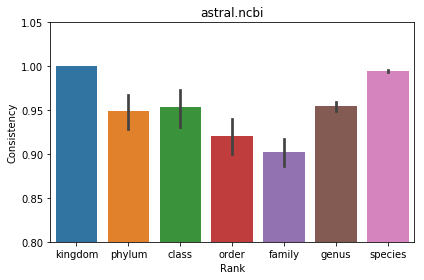

In [42]:
ax = sns.barplot(x='Rank', y='Consistency', data=df)
ax.set_ylim(0.8,)
title = '%s.%s' % (treId, taxId)
ax.set_title(title)
save_sns(ax, '%s.consistency.pdf' % title)

### Analyze node decoration

Match decorations and node IDs.

In [43]:
tree_ori = TreeNode.read('%s.nwk' % treId)
tree_ori.count(tips=True)

10575

In [44]:
tree_t2t = TreeNode.read('%s.%s.t2t.nwk' % (treId, taxId))
tree_t2t.count(tips=True)

10575

Confirm that the decorated tree has the same topology and order of taxa as the original tree.

In [45]:
tree_ori.compare_rfd(tree_t2t)

0.0

In [47]:
nids = []
for node in tree_ori.levelorder():
    if not node.is_tip():
        nids.append(node.name)

In [48]:
decos = []
for node in tree_t2t.levelorder():
    if not node.is_tip():
        decos.append(node.name)

In [49]:
decos[:5]

[None, 'k__Archaea', 'k__Bacteria', None, None]

Generate a rank name table.

In [54]:
nid2label = {}
nid2ranks = {}
for i in range(len(nids)):
    nid = nids[i]
    deco = decos[i]
    nid2ranks[nid] = {x: '' for x in ranks}
    if deco is not None and '__' in deco:
        deco = deco.split(':')[-1]  # remove node support in case there is one
        nid2label[nid] = deco
        for taxon in deco.split('; '):
            code, name = taxon.split('__')
            nid2ranks[nid][code2rank[code]] = name

In [55]:
with open('%s.%s.node_labels.txt' % (treId, taxId), 'w') as f:
    for nid in sorted(nid2label, key=lambda x: int(x.lstrip('N'))):
        f.write('%s\t%s\n' % (nid, nid2label[nid]))

In [56]:
df = pd.DataFrame.from_dict(nid2ranks, orient='index')
df = df.loc[sorted(nid2ranks, key=lambda x: int(x[1:]))]
df.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,,,,,,,
N5,,,,,,,


In [57]:
df.to_csv('%s.%s.node_labels.by_rank.tsv' % (treId, taxId), sep='\t')

### Generate consensus lineage for every node

At a given node, at each rank, check if one taxon can describe all descendants.

In [69]:
nid2ranks = {}
nid2lineage = {}
for nid in nids:
    nid2ranks[nid] = {x: '' for x in ranks}
    nid2lineage[nid] = []
    gids = [x.name for x in tree_ori.find(nid).tips()]
    for code, rank in zip(codes, ranks):
        nid2lineage[nid].append('%s__' % code)
        names = set(gid2ranks[x][rank] for x in gids)
        if len(names) == 1:
            name = max(names)
            nid2ranks[nid][rank] = name
            nid2lineage[nid][-1] += name

In [70]:
with open('%s.%s.node_to_lineage.txt' % (treId, taxId), 'w') as f:
    for nid in sorted(nid2lineage, key=lambda x: int(x[1:])):
        f.write('%s\t%s\n' % (nid, '; '.join(nid2lineage[nid])))

In [71]:
df = pd.DataFrame.from_dict(nid2ranks, orient='index')
df = df.loc[sorted(nid2ranks, key=lambda x: int(x[1:]))]
df.head()

,kingdom,phylum,class,order,family,genus,species
N1,,,,,,,
N2,Archaea,,,,,,
N3,Bacteria,,,,,,
N4,Archaea,,,,,,
N5,Archaea,,,,,,


In [72]:
df.to_csv('%s.%s.node_to_lineage.by_rank.tsv' % (treId, taxId), sep='\t')